In [ ]:
#default_exp vision.augment

# vision.augment
> Contains all the transforms relevent to deployment in the `fastai` library

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastinference_pytorch import utils

In [ ]:
#export 
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from torch import Tensor, tensor
from PIL import Image

In [ ]:
#export
from fastcore.dispatch import patch
from fastcore.utils import mk_class
from fastcore.dispatch import Tuple, retain_type
import operator, math

In [ ]:
from fastcore.test import test_eq

All code and methods originates from the `fastai`, and this library has only implemented parts particular to inference. Another way of saying this is all the transforms are their validation-counterparts only

## Pillow Transforms

In [ ]:
#export
from torchvision.transforms.functional import pad as tvpad

In [ ]:
#export
mk_class('PadMode', **{o:o.lower() for o in ['Zeros', 'Border', 'Reflection']},
         doc="All possible padding mode as attributes to get tab-completion and typo-proofing")

@patch
def _do_crop_pad(x:Image.Image, sz, tl, orig_sz,
                 pad_mode=PadMode.Zeros, resize_mode=Image.BILINEAR, resize_to=None):
    if any(tl.ge(0)):
        # At least one dim is inside the image, so needs to be cropped
        c = tl.max(0)
        x = x.crop((*c, *c.add(sz).min(orig_sz)))
    if any(tl.lt(0)):
        # At least one dim is outside the image, so needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz-p).max(0)
        x = tvpad(x, (*p, *f), padding_mode=_pad_modes[pad_mode])
    if resize_to is not None: x = x.resize(resize_to, resize_mode)
    return x

@patch
def crop_pad(x:Image.Image, sz, tl=None, orig_sz=None, pad_mode=PadMode.Zeros, resize_mode=Image.BILINEAR, resize_to=None):
    if isinstance(sz,int): sz = (sz,sz)
    orig_sz = Tuple(_get_sz(x) if orig_sz is None else orig_sz)
    sz,tl = Tuple(sz),Tuple(((_get_sz(x)-sz)//2) if tl is None else tl)
    return x._do_crop_pad(sz, tl, orig_sz=orig_sz, pad_mode=pad_mode, resize_mode=resize_mode, resize_to=resize_to)

In [ ]:
#export
def _process_sz(size):
    "Ensures that `size` will be a `Tuple`"
    if isinstance(size,int): size=(size,size)
    return Tuple(size[1],size[0])

def _get_sz(x):
    "Returns the current size of `x` as a `Tuple`"
    if isinstance(x, tuple): x = x[0]
    if not isinstance(x, Tensor): return Tuple(x.size)
    return im.size

In [ ]:
im = Image.open('forest.jpg')

In [ ]:
test_eq(_get_sz(im), (2048,1368))

In [ ]:
#export
class CropPad():
    "Center crop or pad an image to `size`"
    order=0
    def __init__(self, size, pad_mode=PadMode.Zeros):
        self.size,self.pad_mode = _process_sz(size),pad_mode
    def __call__(self, x):
        orig_sz = _get_sz(x)
        tl = (orig_sz-self.size)//2
        return x.crop_pad(self.size,tl,orig_sz=orig_sz,pad_mode=self.pad_mode)

In [ ]:
cp = CropPad(224)

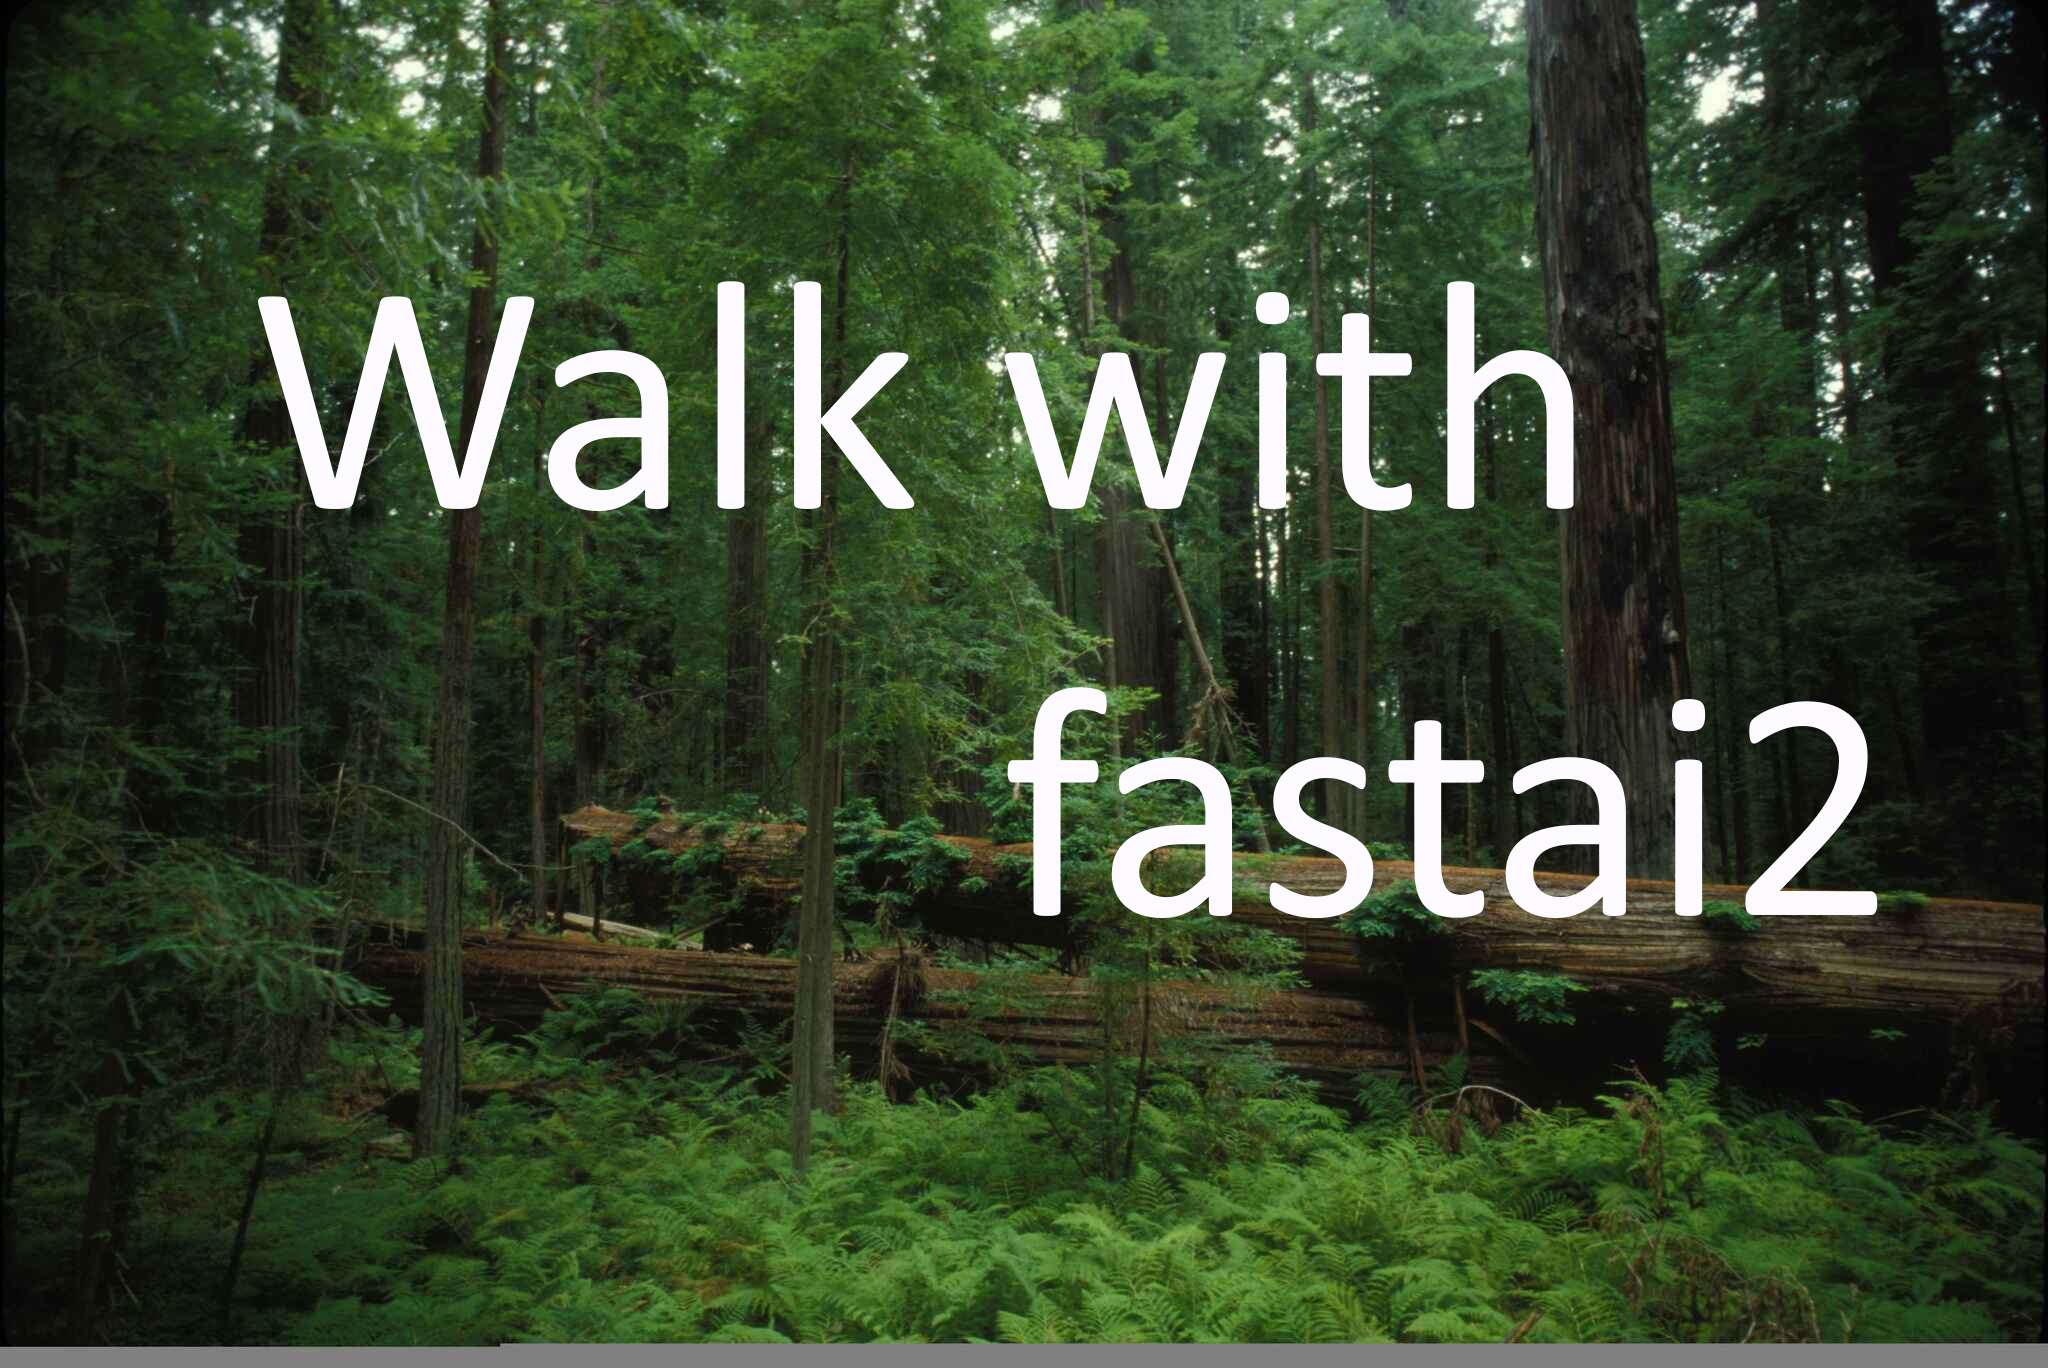

In [ ]:
im

In [ ]:
test_eq(cp(im).size, (224,224))

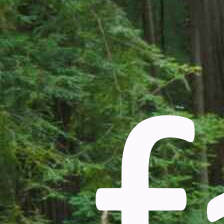

In [ ]:
cp(im)

In [ ]:
RandomCrop = CropPad
OldRandomCrop = RandomCrop

In [ ]:
rc = RandomCrop(224)

In [ ]:
test_eq(rc(im).size, (224,224))

In [ ]:
#export
mk_class('ResizeMethod', **{o:o.lower() for o in ['Squish', 'Crop', 'Pad']},
         doc="All possible resize method as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
class Resize():
    "Resizes an image based on `method` with `pad_mode` and `resample`"
    order = 1
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                resample=Image.BILINEAR):
        self.size,self.pad_mode,self.method = _process_sz(size),pad_mode,method
        self.mode = resample
    
    def __call__(self, x):
        orig_sz = _get_sz(x)
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, Tuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                             resize_method=self.resample, resize_to=self.size)
        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = Tuple(int(.5*(w-cp_sz[0])), int(.5*(h-cp_sz[1])))
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                         resize_mode=self.mode, resize_to=self.size)

In [ ]:
r = Resize(224)
test_eq(r(im).size, (224,224))

In [ ]:
#export
class RandomResizedCrop():
    "Resizes an image randomly to `size` based on `min_scale`, `ratio`, `resample`, and `val_xtra`"
    order = 1
    def __init__(self, size, min_scale=0.08, ratio=(3/4,4/3), resample=Image.BILINEAR,
                val_xtra=0.14):
        size = _process_sz(size)
        self.size,self.min_scale,self.ratio,self.val_xtra = size,min_scale,ratio,val_xtra
        self.mode = resample
    
    def __call__(self, x):
        w,h = self.orig_sz = _get_sz(x)
        xtra = math.ceil(max(*self.size[:2])*self.val_xtra/8)*8
        final_size = (self.size[0]+xtra, self.size[1]+xtra)
        tl = (0,0)
        res = x.crop_pad(self.orig_sz, tl, orig_sz = self.orig_sz,
                        resize_mode=self.mode, resize_to=final_size)
        if final_size != self.size: res = res.crop_pad(self.size)
        return res

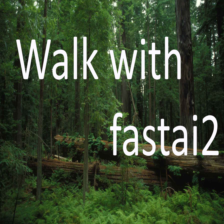

In [ ]:
rrc = RandomResizedCrop(224)
rrc(im)

In [ ]:
#export
class RatioResize():
    "Resizes while maintaining the aspect ratio"
    order = 1
    def __init__(self, max_sz, resample=Image.BILINEAR):
        self.max_sz,self.resample = max_sz, resample
    
    def __call__(self, x):
        w,h = _get_sz(x)
        if w >= h: nw,nh = self.max_sz, h*self.max_sz/w
        else:      nw,nh = w *self.max_sz/h,self.max_sz
        return Resize(size=(int(nh),int(nw)),resample=self.resample)(x)

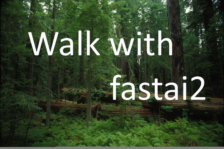

In [ ]:
rr = RatioResize(224)
rr(im)

# PyTorch Transforms

In [ ]:
#export
class Normalize():
    "Normalize based on `mean` and `std` on `axes`"
    order=99
    def __init__(self, mean=None, std=None, axes=(0,2,3)):
        self.mean,self.std,self.axes = mean,std,axes
        
    def __call__(self, x:Tensor, decode=False):
        if not decode: return (x-self.mean)/self.std
        else: 
            f = to_device(x,'cpu') if x.device.type=='cpu' else noop
            return (x*f(self.std) + f(self.mean))

In [ ]:
#export
class IntToFloatTensor():
    "Converts integer to float"
    order = 10
    def __init__(self, div=255., decode=False):
        self.div = div
    def __call__(self, x:Tensor, decode=False):
        if not decode: return o.float().div_(self.div)
        else: return ((o.clamp(0.,1.)*self.div).long()) if self.div else o